<a href="https://colab.research.google.com/github/TheRadDani/Malaria-detection/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import cv2## image processing
import os## operating system
import random
import copy
from google.colab import files
import os
import torch, torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
! pip install -q kaggle

In [ ]:
files.upload()

Saving kaggle(1).json to kaggle(1).json


{'kaggle(1).json': b'{"username":"luisdanielferreto","key":"3583bb24de57d10aa65e0222da1af2fa"}'}

In [ ]:
#! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 675M/675M [00:21<00:00, 30.7MB/s]
100% 675M/675M [00:21<00:00, 32.2MB/s]


In [ ]:
!unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [ ]:
train_paths_parasitized = []
train_paths_uninfected = []

train_paths_parasitized += os.listdir('cell_images/Parasitized')
train_paths_parasitized = ['cell_images/Parasitized/' + i for i in train_paths_parasitized]

train_paths_uninfected += os.listdir('cell_images/Uninfected')
train_paths_uninfected = ['cell_images/Uninfected/' + i for i in train_paths_uninfected]

paths = train_paths_parasitized + train_paths_uninfected

paths.remove("cell_images/Parasitized/Thumbs.db")
paths.remove("cell_images/Uninfected/Thumbs.db")

random.shuffle(paths)

FRACTION = 0.8
train_paths = paths[0:int(FRACTION*len(paths))]
val_paths = paths[int(FRACTION*len(paths)):]
print(len(val_paths), len(train_paths))

5512 22046


In [ ]:
class Malaria(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])
    
    if(self.image_filepaths[index].split('/')[1] == 'Parasitized'):
      label = 0.0
    else:
      label = 1.0

    
    if self.transform:
      image = self.transform(image = image)['image']
    
    return image, label


In [ ]:
#@title Python library for data augmentations techniques
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-2lq12o3l
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-2lq12o3l
  Resolved https://github.com/albu/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125696 sha256=f89e0fba6b72eff41670ba37acaf9406bb4d7b2dbf4fedc1b010eda68623eb31
  Stored in directory: /tmp/pip-ephem-wheel-cache-plmaakzo/wheels/3c/df/16/b3d0d64428c9f25b1ab03989a2e574546d3336647946d31e56
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
#@title Data augmentation techniques from albumentations library
IM_SIZE = 224
transform = A.Compose([
                        A.Resize(IM_SIZE, IM_SIZE),

                        A.OneOf([A.HorizontalFlip(),
                                 A.VerticalFlip(),], p = 0.3),
                        
                        A.RandomRotate90(),   
                        A.RandomBrightnessContrast(brightness_limit=0.2,
                                                  contrast_limit=0.2,
                                                  always_apply=False, p=0.5),
                        A.Normalize(),
                       
                        
])

In [ ]:
#@title Splitting and labeling dataset accordingly
train_dataset = Malaria(train_paths, transform)
val_dataset = Malaria(val_paths, transform)

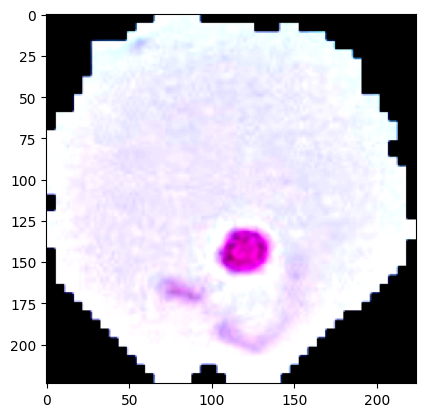

In [ ]:
plt.imshow(train_dataset[0][0]);

It is a common practice in batch processing to increase the batch size of the validation data relative to the training data because the validation set is used to evaluate the model's performance during training and the goal is to detect overfitting as early as possible. By increasing the batch size of the validation data, we can reduce the variance of the validation error estimate and improve the accuracy of the early stopping criterion.

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE*2)

In [ ]:
image, label = next(iter(train_loader))
print(image[2][100:150,100:150,0])

tensor([[-0.2342, -0.2342, -0.2342,  ..., -0.1999, -0.1828, -0.1828],
        [-0.2342, -0.2342, -0.2342,  ..., -0.1999, -0.1999, -0.1999],
        [-0.2513, -0.2513, -0.2513,  ..., -0.2171, -0.1999, -0.1999],
        ...,
        [-0.2856, -0.2856, -0.3027,  ..., -0.2856, -0.2856, -0.2856],
        [-0.3027, -0.3027, -0.3027,  ..., -0.2684, -0.2856, -0.2856],
        [-0.3027, -0.3027, -0.3198,  ..., -0.2684, -0.2856, -0.2856]])


Text(0.5, 1.0, 'Label: 0')

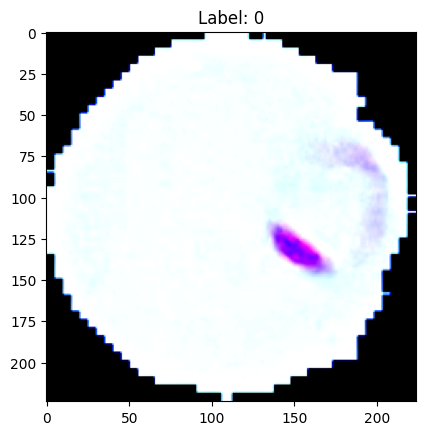

In [ ]:
plt.imshow(image[0])
plt.title(f"Label: {int(label[0].item())}")

When batch_norm layers are added after convolutional layers in a CNN, they help to stabilize the activations of the layer and reduce the effects of covariate shift, which can improve the gradient flow through the network and reduce the likelihood of overfitting. This can lead to faster training and better accuracy.

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
      super(LeNet, self).__init__()
      
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
      self.bn1 = nn.BatchNorm2d(6)
      self.pool1 = nn.MaxPool2d(2,2)
      self.dropout1 = nn.Dropout2d(0.2)

      self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.bn2 = nn.BatchNorm2d(16)
      self.pool2 = nn.MaxPool2d(2,2)

      self.fc3 = nn.Linear(50176, 100)
      self.bn3 = nn.BatchNorm1d(100)
      
      self.fc4 = nn.Linear(100, 10)
      self.bn4 = nn.BatchNorm1d(10)
      
      self.fc5 = nn.Linear(10, 1)
        
    def forward(self, input):

      output = self.dropout1(self.pool1(self.bn1(F.relu(self.conv1(input)))))
      output = self.pool2(self.bn2(F.relu(self.conv2(output))))
      
      output = output.reshape(-1, 16*56*56) #flatten layer
      output = self.bn3(F.relu(self.fc3(output)))
      output = self.bn4(F.relu(self.fc4(output)))

      output = torch.sigmoid(self.fc5(output))
        
      return output


model = LeNet()

model(torch.zeros((3,3,224,224)))                   

tensor([[0.5015],
        [0.5015],
        [0.5949]], grad_fn=<SigmoidBackward0>)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
loss_fn = torch.nn.BCELoss()
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr, )

cuda:0


In [ ]:
#@title Threshold for binary classification
def round(x):
  if(x>= 0.5):
    return 1.
  else:
    return 0.

In [ ]:
#@title Original image's shape
print("Single image's shape: ",image[0].shape)
a = val_loader
#before permuting
print("Shape of image before permuting",next(iter(a))[0].shape)
#after permuting
print("Shape of image after permuting",torch.permute(next(iter(a))[0], (0,3,1,2)).shape)

Single image's shape:  torch.Size([224, 224, 3])
Shape of image before permuting torch.Size([64, 224, 224, 3])
Shape of image after permuting torch.Size([64, 3, 224, 224])


In [84]:
def get_accuracy(epoch):
  
  model.eval()
  with torch.no_grad():
    epoch_accuracy = 0 
    for i, (image, label) in enumerate(val_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      output = model(image)

      for i in range(len(output)):
        if(round(output[i].item()) == label[i].item()):
          epoch_accuracy += 1
    accuracy = epoch_accuracy/len(val_dataset)
  
    return accuracy

In [89]:
def train(EPOCHS):
  accuracy_list = list()
  COST = list()                      
  model.to(device)
  
  for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for i, (image, label) in enumerate(train_loader):

      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)
      
      label = torch.unsqueeze(label, -1)
      label = label.float()
      label = label.to(device)

      #forward pass
      optimizer.zero_grad()

      output = model(image)

      loss = loss_fn(output, label)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    

      step_length = int(len(train_loader)/2)
    
      if(i%step_length) == 0:
              print('Epoch Number: {}, step: [{}|{}] ----> Loss: {}' .format(epoch+1, i, len(train_loader), loss.item()))
    
    COST.append(epoch_loss)
    
    print("Loss for epoch Number {} is :{}".format(epoch+1, epoch_loss/len(train_loader)))
    
    accuracy = get_accuracy(epoch)

    accuracy_list.append(accuracy)

    print("The Validation Accuracy for this epoch:{} is:{} ".format(epoch+1, 100*accuracy))

  folder_path = "./model"

  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

  torch.save(model.state_dict(), f'{folder_path}/malaria_detection_model.pth')
  return accuracy_list,COST


In [90]:
accuracy_list,COST = train(20)

Epoch Number: 1, step: [0|689] ----> Loss: 0.002645823173224926
Epoch Number: 1, step: [344|689] ----> Loss: 0.005306098610162735
Epoch Number: 1, step: [688|689] ----> Loss: 0.002327537629753351
Loss for epoch Number 1 is :0.025711962760486762
The Validation Accuracy for this epoch:1 is:94.92017416545718 
Epoch Number: 2, step: [0|689] ----> Loss: 0.017959963530302048
Epoch Number: 2, step: [344|689] ----> Loss: 0.0016152113676071167
Epoch Number: 2, step: [688|689] ----> Loss: 0.004096724558621645
Loss for epoch Number 2 is :0.02827344287956655
The Validation Accuracy for this epoch:2 is:94.66618287373004 
Epoch Number: 3, step: [0|689] ----> Loss: 0.28284749388694763
Epoch Number: 3, step: [344|689] ----> Loss: 0.004248527344316244
Epoch Number: 3, step: [688|689] ----> Loss: 0.014064338989555836
Loss for epoch Number 3 is :0.02377682748078406
The Validation Accuracy for this epoch:3 is:93.99492017416546 
Epoch Number: 4, step: [0|689] ----> Loss: 0.003720139618963003
Epoch Number: 

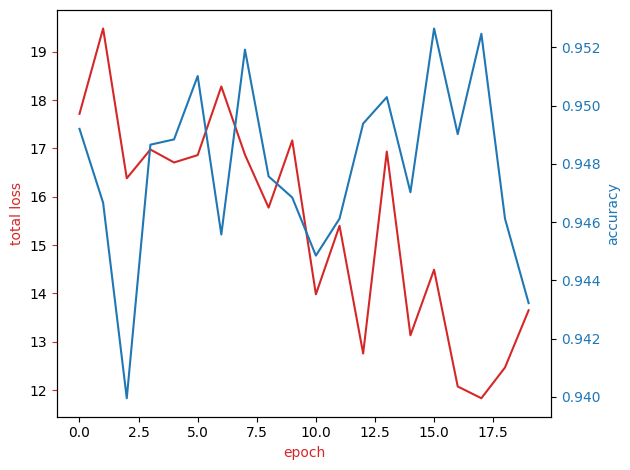

In [91]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(COST,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

In [102]:
folder_path = './model'

if os.path.exists(folder_path) and os.listdir(folder_path):
  #model = YourModelClass(*args, **kwargs) # create an instance of your model
  model.load_state_dict(torch.load(f'{folder_path}/malaria_detection_model.pth'))
  model.eval() # switch
  print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'fc3.weight', 'fc3.bias', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'fc4.weight', 'fc4.bias', 'bn4.weight', 'bn4.bias', 'bn4.running_mean', 'bn4.running_var', 'bn4.num_batches_tracked', 'fc5.weight', 'fc5.bias'])
